In [ ]:
import pandas as pd
import numpy as np

In [ ]:
data = pd.read_csv('/Users/rookie/Desktop/raw_partner_headlines.csv')

In [ ]:
data.tail(20)
data.iloc[9:25, 0:3]
data.head()

,Unnamed: 0,headline,url,publisher,date,stock,Year,Month
0,2,Agilent Technologies Announces Pricing of $5……...,http://www.gurufocus.com/news/1153187/agilent-...,GuruFocus,2020-06-01 00:00:00,A,2020,6
1,3,Agilent (A) Gears Up for Q2 Earnings: What's i...,http://www.zacks.com/stock/news/931205/agilent...,Zacks,2020-05-18 00:00:00,A,2020,5
2,4,J.P. Morgan Asset Management Announces Liquida...,http://www.gurufocus.com/news/1138923/jp-morga...,GuruFocus,2020-05-15 00:00:00,A,2020,5
3,5,"Pershing Square Capital Management, L.P. Buys ...",http://www.gurufocus.com/news/1138704/pershing...,GuruFocus,2020-05-15 00:00:00,A,2020,5
4,6,Agilent Awards Trilogy Sciences with a Golden ...,http://www.gurufocus.com/news/1134012/agilent-...,GuruFocus,2020-05-12 00:00:00,A,2020,5


In [ ]:
data.stock.unique()

array(['A', 'AA', 'AAC', ..., 'ZU', 'ZUMZ', 'ZX'], dtype=object)

In [ ]:
# most mentioned stocks: KR, GXC, PGJ, YINN, JPM
data.stock.value_counts()

KR      3314
GXC     3238
PGJ     3082
YINN    3027
JPM     2873
        ... 
SBNA       1
I          1
EZT        1
GJV        1
WREI       1
Name: stock, Length: 6552, dtype: int64

In [ ]:
#build year and month columns
data['Year'] = pd.DatetimeIndex(data['date']).year
data['Month'] = pd.DatetimeIndex(data['date']).month
data.tail()

,Unnamed: 0,headline,url,publisher,date,stock,Year,Month
1845554,1849874,Consumer Cyclical Sector Wrap,https://www.benzinga.com/content/12/08/2846030...,webmaster,2012-08-20 00:00:00,ZX,2012,8
1845555,1849875,Consumer Cyclical Sector Wrap,https://www.benzinga.com/content/12/07/2767124...,webmaster,2012-07-23 00:00:00,ZX,2012,7
1845556,1849876,Zacks #5 Rank Additions for Monday - Tale of t...,http://www.zacks.com/stock/news/73497/here-are...,Zacks,2012-04-23 00:00:00,ZX,2012,4
1845557,1849877,4 Stock Strategies From Wall Street: Feb. 9 (U...,http://www.thestreet.com/story/11409053/1/4-st...,TheStreet.Com,2012-02-09 00:00:00,ZX,2012,2
1845558,1849878,4 Stock Strategies From Wall Street: Feb. 9,https://www.benzinga.com/content/thestreet-com...,webmaster,2012-02-09 00:00:00,ZX,2012,2


In [ ]:
#! pip install tweet-preprocessor
# https://github.com/s/preprocessor

In [ ]:
##type(data.Year[0])

In [ ]:
##check for nan 
#data["Year"]
#import math

#def isNotNan(x):
    #return not(math.isnan(x))

#data = data[data.Year.apply(isNotNan)]
#data["Year"].describe()


In [ ]:
#segment data to before 2018 and after
data2 = data[data['Year']<=2018]
data3= data[data['Year']>2018]

In [ ]:
data2['Year'].unique()

array([2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 1969])

In [ ]:
data3['Year'].unique()

array([2020, 2019])

In [ ]:
#pip install -U gensim

In [ ]:
##topic modeling for before 2018
import re
from sklearn import feature_extraction 
stop_words = feature_extraction.text.ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

import nltk 
nltk.download('words')
words = set(nltk.corpus.words.words())

import preprocessor as p
p.set_options(p.OPT.URL, p.OPT.EMOJI,p.OPT.MENTION,p.OPT.HASHTAG)
p.set_options(p.OPT.URL, p.OPT.EMOJI,p.OPT.MENTION)

def remove_html_tags(text):
    """Remove html tags from a string"""
    import re
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

def preprocess(text):
  text = text.lower() #lowercase
  text = p.clean(text)
  text = remove_html_tags(text)
  text = re.sub(r'[^\w\s]', '', text) #remove punctuations
  text = re.sub(r'\d+', '', text) #remove numbers
  text = " ".join(text.split()) #stripWhitespace
  text = text.split()
  text = [x for x in text if x not in stop_words] #remove stopwords
  text = [x for x in text if x not in ['stock','stocks',"q",'results','blog','outlook','analyst','transcript','tape','tale']] #remove task specific stopwords
  text = [x for x in text if len(x)>2]
  text = " ".join(text)
  # stemmer_ps = PorterStemmer()  
  # text = [stemmer_ps.stem(word) for word in text.split()] #stemming
  # text = " ".join(text)
  # lemmatizer = WordNetLemmatizer()
  # text = [lemmatizer.lemmatize(word) for word in text.split()]  #lemmatization
  # text = " ".join(text)
  return(text)


data2['text_processed']=data2['headline'].apply(lambda x:preprocess(str(x)))
data2['text_processed']=data2['text_processed'].apply(lambda x:x.split())

from gensim import corpora
dictionary = corpora.Dictionary(data2['text_processed'])
dictionary.filter_extremes(keep_n=5000)
data2['text_ids']=data2['text_processed'].apply(lambda x:dictionary.doc2bow(x))
from gensim import models
num_topics=4
ldamodel = models.ldamodel.LdaModel(data2['text_ids'], num_topics = 4, id2word=dictionary, passes=1, random_state=100)

topics = ldamodel.print_topics(num_words=8)
for i in range(num_topics):
    print(topics[i])

[nltk_data] Downloading package words to /Users/rookie/nltk_data...
[nltk_data]   Package words is already up-to-date!
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

(0, '0.015*"buys" + 0.014*"oil" + 0.013*"energy" + 0.013*"etf" + 0.012*"losers" + 0.012*"update" + 0.011*"portfolio" + 0.011*"china"')
(1, '0.094*"earnings" + 0.030*"dividend" + 0.019*"ceo" + 0.015*"news" + 0.013*"market" + 0.012*"beat" + 0.012*"estimates" + 0.011*"notable"')
(2, '0.024*"week" + 0.015*"high" + 0.013*"sales" + 0.013*"higher" + 0.013*"new" + 0.012*"strong" + 0.012*"retail" + 0.011*"buy"')
(3, '0.031*"china" + 0.029*"beats" + 0.021*"trade" + 0.020*"revenue" + 0.015*"yahoo" + 0.015*"misses" + 0.015*"reports" + 0.014*"zumiez"')


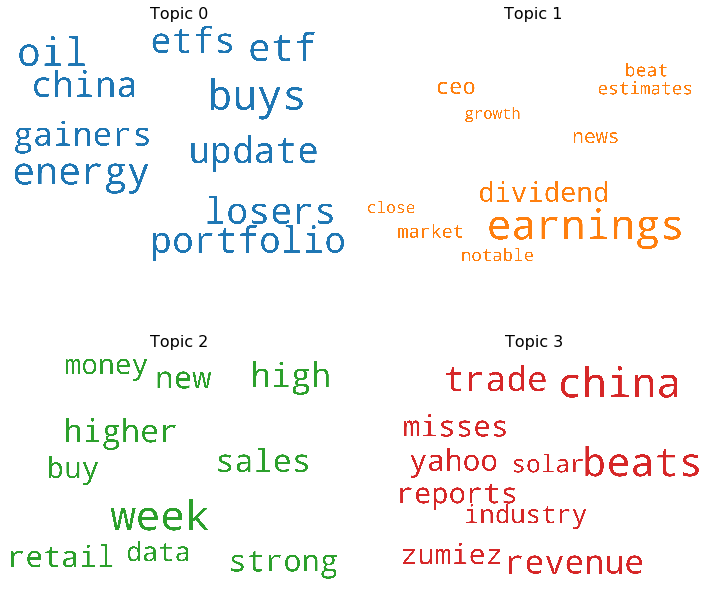

In [ ]:
##worldcloud for the topics before 2018
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=15,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = ldamodel.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
##save the model 

In [ ]:
#from gensim import models
ldamodel.save('model.lda')
ldamodel =  models.LdaModel.load('model.lda')

In [ ]:
pd.DataFrame(ldamodel.get_topics(), columns=ldamodel.id2word.values(), index=[f'topic {i}' for i in range(ldamodel.num_topics)])

,dividend,increases,round,upcoming,biotechnology,dashboard,healthcare,update,agilent,bio,...,rci,energizer,macau,yingli,madden,railroad,ruble,vivint,eurusd,sensex
topic 0,1.156755e-07,1.145780e-07,1.152599e-07,1.145426e-07,3.549294e-04,2.780592e-03,1.680958e-03,1.150496e-02,1.136969e-07,1.151915e-07,...,1.187927e-07,1.170084e-07,6.903196e-07,2.070554e-07,1.232250e-07,1.197792e-07,9.152196e-05,0.000042,1.237597e-07,1.502537e-07
topic 1,2.967093e-02,3.922673e-03,2.955238e-03,9.522079e-04,1.735944e-07,1.705362e-07,1.139523e-03,1.723726e-07,4.945968e-05,1.744890e-07,...,1.771171e-07,1.768940e-07,2.161486e-07,3.074247e-07,8.119383e-05,1.783477e-07,2.028032e-07,0.000011,1.781985e-07,1.867260e-07
topic 2,1.666322e-07,1.663632e-07,3.166424e-03,1.685656e-07,1.749108e-07,1.667592e-07,2.288776e-03,1.701396e-07,1.842534e-07,3.537722e-04,...,4.973165e-05,1.732130e-07,2.248430e-05,2.768138e-07,1.776194e-07,1.938984e-07,2.061704e-07,0.000047,2.920262e-05,2.796003e-07
topic 3,2.016613e-07,2.014824e-07,2.032568e-07,2.023633e-07,2.171743e-07,2.014571e-07,2.239547e-07,2.029576e-07,2.000145e-07,2.055677e-07,...,2.118026e-07,4.669360e-05,2.031898e-07,3.348811e-03,2.077618e-07,7.718083e-05,2.025623e-07,0.000488,2.042013e-07,1.999777e-07


In [ ]:
# #! pip install pyLDAvis
import pyLDAvis.gensim
import pickle 
import pyLDAvis
import nltk

In [ ]:
#visualize the topics and most salient words
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel,corpus=data2['text_ids'], dictionary=ldamodel.id2word)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.002911  0.012759       1        1  32.315750
2      0.110507 -0.347038       2        1  24.330595
1      0.262840  0.256750       3        1  23.530378
3     -0.376259  0.077529       4        1  19.823275, topic_info=         Term           Freq          Total Category  logprob  loglift
33   earnings  145255.000000  145255.000000  Default  30.0000  30.0000
0    dividend   46039.000000   46039.000000  Default  29.0000  29.0000
48      beats   37957.000000   37957.000000  Default  28.0000  28.0000
227     china   63819.000000   63819.000000  Default  27.0000  27.0000
66       week   38394.000000   38394.000000  Default  26.0000  26.0000
..        ...            ...            ...      ...      ...      ...
68        new   10892.228516   37030.867188   Topic4  -4.7876   0.3946
174    market   10843.424805   56913.152344   Topic4  -4.7921  -0.0397
480      deal    7363.773926   14441.806641   Topic4  -5.1791   0.9448
28      watch    6908.250000   11982.394531   Topic4  -5.2429   1.0676
299     foods    6406.901367    9174.371094   Topic4  -5.3183   1.2593

[187 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
396       1  0.001837   apple
396       4  0.998094   apple
1064      1  0.999926    bank
1340      2  0.999881   banks
908       4  0.999865    bear
...     ...       ...     ...
2039      3  0.000335  zoetis
2039      4  0.999329  zoetis
4469      2  0.000054  zumiez
4469      3  0.000054  zumiez
4469      4  0.999896  zumiez

[185 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4])

In [ ]:
#topic modeling for after 2018
import re
from sklearn import feature_extraction 
stop_words = feature_extraction.text.ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

import nltk 
nltk.download('words')
words = set(nltk.corpus.words.words())

import preprocessor as p
p.set_options(p.OPT.URL, p.OPT.EMOJI,p.OPT.MENTION,p.OPT.HASHTAG)
p.set_options(p.OPT.URL, p.OPT.EMOJI,p.OPT.MENTION)

def remove_html_tags(text):
    """Remove html tags from a string"""
    import re
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

def preprocess(text):
  text = text.lower() #lowercase
  text = p.clean(text)
  text = remove_html_tags(text)
  # text = " ".join(w for w in nltk.wordpunct_tokenize(text) if w.lower() in words or not w.isalpha()) #non-English
  text = re.sub(r'[^\w\s]', '', text) #remove punctuations
  text = re.sub(r'\d+', '', text) #remove numbers
  text = " ".join(text.split()) #stripWhitespace
  text = text.split()
  text = [x for x in text if x not in stop_words] #remove stopwords
  text = [x for x in text if x not in ['stock','stocks',"q",'result','analyst','declares','whats','transcript','results','week','weekly']] #remove task specific stopwords
  text = [x for x in text if len(x)>2]
  text = " ".join(text)
  # stemmer_ps = PorterStemmer()  
  # text = [stemmer_ps.stem(word) for word in text.split()] #stemming
  # text = " ".join(text)
  # lemmatizer = WordNetLemmatizer()
  # text = [lemmatizer.lemmatize(word) for word in text.split()]  #lemmatization
  # text = " ".join(text)
  return(text)


data3['text_processed']=data3['headline'].apply(lambda x:preprocess(str(x)))
data3['text_processed']=data3['text_processed'].apply(lambda x:x.split())

from gensim import corpora
dictionary = corpora.Dictionary(data3['text_processed'])
# dictionary.filter_extremes(keep_n=5000)
data3['text_ids']=data3['text_processed'].apply(lambda x:dictionary.doc2bow(x))
from gensim import models
num_topics=4
ldamodel1 = models.ldamodel.LdaModel(data3['text_ids'], num_topics = 4, id2word=dictionary, passes=1, random_state=100)

topics = ldamodel1.print_topics(num_words=8)
for i in range(num_topics):
    print(topics[i])

[nltk_data] Downloading package words to /Users/rookie/nltk_data...
[nltk_data]   Package words is already up-to-date!
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

(0, '0.042*"earnings" + 0.013*"report" + 0.013*"dividend" + 0.012*"estimates" + 0.011*"investors" + 0.011*"beat" + 0.010*"highlights" + 0.009*"revenues"')
(1, '0.050*"buys" + 0.023*"etf" + 0.022*"llc" + 0.019*"management" + 0.018*"corp" + 0.015*"capital" + 0.014*"vanguard" + 0.014*"ishares"')
(2, '0.055*"earnings" + 0.019*"beats" + 0.019*"revenue" + 0.018*"ceo" + 0.018*"watch" + 0.017*"oil" + 0.011*"misses" + 0.010*"reports"')
(3, '0.036*"market" + 0.019*"buy" + 0.017*"trade" + 0.012*"china" + 0.010*"new" + 0.010*"growth" + 0.008*"markets" + 0.007*"fed"')


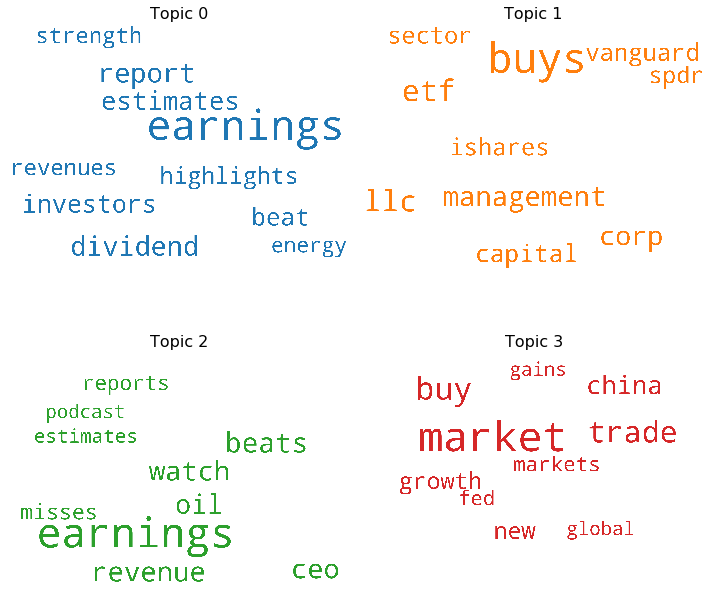

In [ ]:
##worldcloud
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=15,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = ldamodel1.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
from gensim import models
ldamodel1.save('model.lda')
ldamodel1 =  models.LdaModel.load('model.lda')

In [ ]:
#visualize the most salient words after 2018
import pyLDAvis.gensim
import pickle 
import pyLDAvis
import nltk
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel1,corpus=data3['text_ids'], dictionary=ldamodel1.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.100125  0.351812       1        1  30.153677
1      0.306321 -0.062841       2        1  24.885590
0      0.088508 -0.080077       3        1  22.819550
3     -0.294704 -0.208894       4        1  22.141186, topic_info=         Term          Freq         Total Category  logprob  loglift
16       buys  48807.000000  48807.000000  Default  30.0000  30.0000
49     market  25189.000000  25189.000000  Default  29.0000  29.0000
125  dividend  21559.000000  21559.000000  Default  28.0000  28.0000
8    earnings  60387.000000  60387.000000  Default  27.0000  27.0000
267   results  18636.000000  18636.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
256       buy   7743.339355  15252.074219   Topic4  -4.4632   0.8298
8    earnings  16693.546875  60387.414062   Topic4  -3.6950   0.2220
887      deal   3982.480225   5214.632812   Topic4  -5.1281   1.2382
283       new   5715.897461  11208.921875   Topic4  -4.7667   0.8343
626   reports   4097.394043   5587.628906   Topic4  -5.0996   1.1975

[207 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
337       4  0.999934    action
347       1  0.999921  advisors
307       1  0.999754     ahead
156       4  0.999826     alert
73        2  0.999830      amid
...     ...       ...       ...
2494      4  0.000249    zoetis
8411      1  0.000236    zumiez
8411      2  0.000236    zumiez
8411      3  0.999221    zumiez
8411      4  0.000472    zumiez

[248 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 4])

In [ ]:
#Finding the dominant topic in each headline (after 2018)
def format_topics_sentences(ldamodel=ldamodel1, corpus=data3['text_ids'], texts=data3['headline']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel1, corpus= data3['text_ids'], texts=data3['text_processed'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(20)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.5408,"earnings, investors, report, results, value, o...","[agilent, technologies, announces, pricing, mi..."
1,1,2.0,0.7099,"earnings, week, estimates, trade, market, beat...","[agilent, gears, earnings, whats, cards]"
2,2,0.0,0.5313,"earnings, investors, report, results, value, o...","[morgan, asset, management, announces, liquida..."
3,3,1.0,0.7420,"buys, etf, llc, management, corp, market, capi...","[pershing, square, capital, management, buys, ..."
4,4,2.0,0.4838,"earnings, week, estimates, trade, market, beat...","[agilent, awards, trilogy, sciences, golden, t..."
5,5,3.0,0.7901,"earnings, etfs, beats, revenue, ceo, watch, re...","[agilent, technologies, ceo, president, michae..."
6,6,0.0,0.8080,"earnings, investors, report, results, value, o...","[growing, earnings, fast]"
7,7,1.0,0.9249,"buys, etf, llc, management, corp, market, capi...","[cypress, asset, management, buys, verizon, co..."
8,8,1.0,0.9159,"buys, etf, llc, management, corp, market, capi...","[hendley, buys, american, electric, power, agi..."
9,9,1.0,0.5558,"buys, etf, llc, management, corp, market, capi...","[teacher, retirement, texas, buys, hologic, va..."


In [ ]:
#Find the most representative document for each topic

# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9443,"earnings, investors, report, results, value, o...",NaN
1,1.0,0.9558,"buys, etf, llc, management, corp, market, capi...",NaN
2,2.0,0.9478,"earnings, week, estimates, trade, market, beat...",NaN
3,3.0,0.9415,"earnings, etfs, beats, revenue, ceo, watch, re...",NaN


In [ ]:
print(df_topic_sents_keywords.groupby('Dominant_Topic').size())

Dominant_Topic
0.0     90167
1.0    162907
2.0    133700
3.0     78143
dtype: int64


In [ ]:
#segment the data and take a deeper look at the five most frequently talked stocks/etfs 

In [ ]:
data4 = data[data.stock=="YINN"]

In [ ]:
len(data4)

3027

In [ ]:
data5 = data[data.stock=="KR"]

In [ ]:
data6=data[data.stock=="GXC"]

In [ ]:
data7=data[data.stock=="PGJ"]

In [ ]:
data8=data[data.stock=="JPM"]   

In [ ]:
len(data5)

3314

In [ ]:
len(data8)

2873

In [ ]:
##topic modeling for KR 
import re
from sklearn import feature_extraction 
stop_words = feature_extraction.text.ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

import nltk 
nltk.download('words')
words = set(nltk.corpus.words.words())

import preprocessor as p
p.set_options(p.OPT.URL, p.OPT.EMOJI,p.OPT.MENTION,p.OPT.HASHTAG)
p.set_options(p.OPT.URL, p.OPT.EMOJI,p.OPT.MENTION)

def remove_html_tags(text):
    """Remove html tags from a string"""
    import re
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

def preprocess(text):
  text = text.lower() #lowercase
  text = p.clean(text)
  text = remove_html_tags(text)
  text = re.sub(r'[^\w\s]', '', text) #remove punctuations
  text = re.sub(r'\d+', '', text) #remove numbers
  text = " ".join(text.split()) #stripWhitespace
  text = text.split()
  text = [x for x in text if x not in stop_words] #remove stopwords
  text = [x for x in text if x not in ['chinas','stock','stocks',"q",'results','blog','outlook','analyst','Kroger','kroger']] #remove task specific stopwords
  text = [x for x in text if len(x)>2]
  text = " ".join(text)
  # stemmer_ps = PorterStemmer()  
  # text = [stemmer_ps.stem(word) for word in text.split()] #stemming
  # text = " ".join(text)
  # lemmatizer = WordNetLemmatizer()
  # text = [lemmatizer.lemmatize(word) for word in text.split()]  #lemmatization
  # text = " ".join(text)
  return(text)


data5['text_processed']=data5['headline'].apply(lambda x:preprocess(str(x)))
data5['text_processed']=data5['text_processed'].apply(lambda x:x.split())

from gensim import corpora
dictionary = corpora.Dictionary(data5['text_processed'])
dictionary.filter_extremes(keep_n=5000)
data5['text_ids']=data5['text_processed'].apply(lambda x:dictionary.doc2bow(x))
from gensim import models
num_topics=4
ldamodel2 = models.ldamodel.LdaModel(data5['text_ids'], num_topics = 4, id2word=dictionary, passes=1, random_state=100)

topics = ldamodel2.print_topics(num_words=8)
for i in range(num_topics):
    print(topics[i])

[nltk_data] Downloading package words to /Users/rookie/nltk_data...
[nltk_data]   Package words is already up-to-date!
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

(0, '0.092*"earnings" + 0.026*"foods" + 0.023*"season" + 0.020*"estimates" + 0.018*"miss" + 0.018*"beat" + 0.017*"market" + 0.017*"sales"')
(1, '0.031*"foods" + 0.025*"new" + 0.024*"high" + 0.021*"earnings" + 0.018*"grocery" + 0.016*"amazon" + 0.014*"strong" + 0.014*"market"')
(2, '0.057*"earnings" + 0.030*"buy" + 0.029*"week" + 0.024*"preview" + 0.021*"dividend" + 0.018*"growth" + 0.017*"money" + 0.015*"market"')
(3, '0.044*"walmart" + 0.020*"community" + 0.020*"stars" + 0.020*"vetr" + 0.019*"market" + 0.018*"news" + 0.014*"upgraded" + 0.013*"buys"')


In [ ]:
from gensim import models
ldamodel2.save('model.lda')
ldamodel2 =  models.LdaModel.load('model.lda')

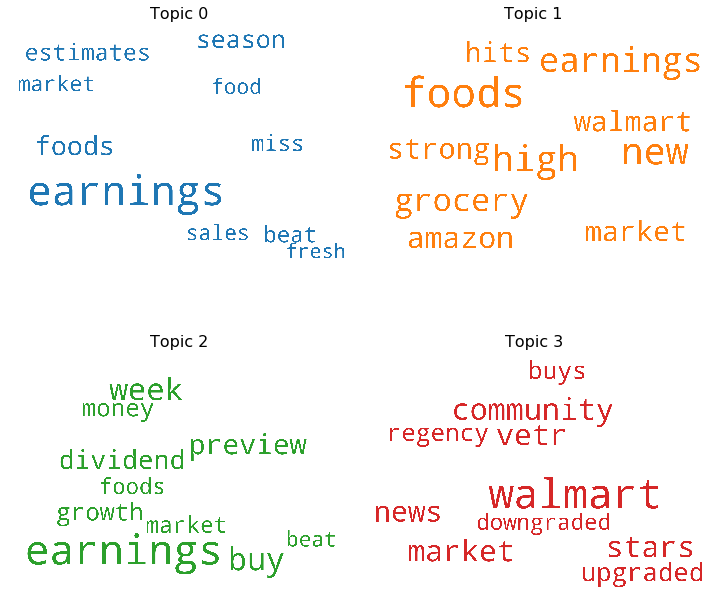

In [ ]:
##worldcloud
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()] 
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = ldamodel2.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
#topic modeling for Yinn 
import re
from sklearn import feature_extraction 
stop_words = feature_extraction.text.ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

import nltk 
nltk.download('words')
words = set(nltk.corpus.words.words())

import preprocessor as p
p.set_options(p.OPT.URL, p.OPT.EMOJI,p.OPT.MENTION,p.OPT.HASHTAG)
p.set_options(p.OPT.URL, p.OPT.EMOJI,p.OPT.MENTION)

def remove_html_tags(text):
    """Remove html tags from a string"""
    import re
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

def preprocess(text):
  text = text.lower() #lowercase
  text = p.clean(text)
  text = remove_html_tags(text)
  # text = " ".join(w for w in nltk.wordpunct_tokenize(text) if w.lower() in words or not w.isalpha()) #non-English
  text = re.sub(r'[^\w\s]', '', text) #remove punctuations
  text = re.sub(r'\d+', '', text) #remove numbers
  text = " ".join(text.split()) #stripWhitespace
  text = text.split()
  text = [x for x in text if x not in stop_words] #remove stopwords
  text = [x for x in text if x not in ['chinas','stock','stocks',"q",'results','blog','outlook','analyst']] #remove task specific stopwords
  text = [x for x in text if len(x)>2]
  text = " ".join(text)
  # stemmer_ps = PorterStemmer()  
  # text = [stemmer_ps.stem(word) for word in text.split()] #stemming
  # text = " ".join(text)
  # lemmatizer = WordNetLemmatizer()
  # text = [lemmatizer.lemmatize(word) for word in text.split()]  #lemmatization
  # text = " ".join(text)
  return(text)


data4['text_processed']=data4['headline'].apply(lambda x:preprocess(str(x)))
data4['text_processed']=data4['text_processed'].apply(lambda x:x.split())

from gensim import corpora
dictionary = corpora.Dictionary(data4['text_processed'])
dictionary.filter_extremes(keep_n=5000)
data4['text_ids']=data4['text_processed'].apply(lambda x:dictionary.doc2bow(x))
from gensim import models
num_topics=4
ldamodel3 = models.ldamodel.LdaModel(data4['text_ids'], num_topics = 4, id2word=dictionary, passes=1, random_state=100)

topics = ldamodel3.print_topics(num_words=8)
for i in range(num_topics):
    print(topics[i])

[nltk_data] Downloading package words to /Users/rookie/nltk_data...
[nltk_data]   Package words is already up-to-date!
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

(0, '0.098*"chinese" + 0.069*"china" + 0.038*"growth" + 0.017*"new" + 0.016*"gdp" + 0.014*"trade" + 0.013*"pmi" + 0.012*"market"')
(1, '0.187*"china" + 0.029*"market" + 0.023*"chinese" + 0.020*"gold" + 0.018*"growth" + 0.015*"economy" + 0.014*"trade" + 0.009*"asian"')
(2, '0.119*"china" + 0.031*"data" + 0.025*"global" + 0.023*"chinese" + 0.020*"market" + 0.016*"crash" + 0.016*"economic" + 0.015*"week"')
(3, '0.062*"trade" + 0.054*"markets" + 0.021*"economic" + 0.020*"shanghai" + 0.019*"war" + 0.019*"global" + 0.019*"china" + 0.017*"chinese"')


In [ ]:
from gensim import models
ldamodel3.save('model.lda')
ldamodel3 =  models.LdaModel.load('model.lda')

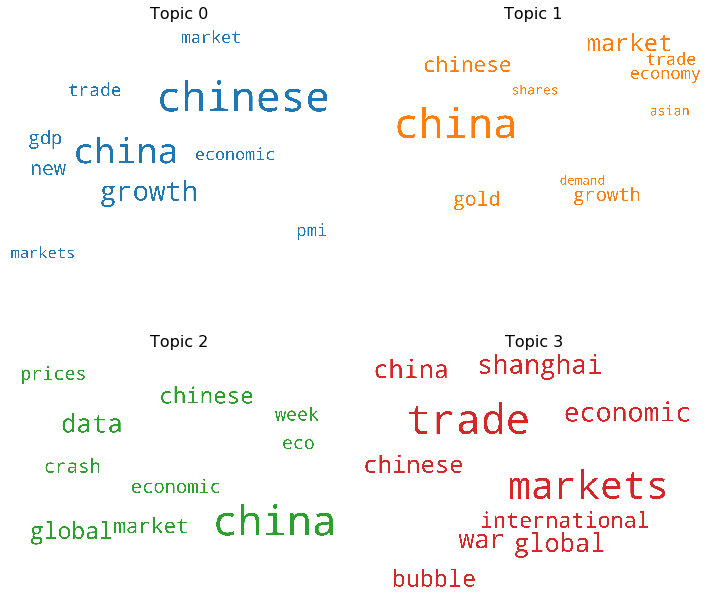

In [ ]:
##worldcloud
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = ldamodel3.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
##topic modeling for GXC 
import re
from sklearn import feature_extraction 
stop_words = feature_extraction.text.ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

import nltk 
nltk.download('words')
words = set(nltk.corpus.words.words())

import preprocessor as p
p.set_options(p.OPT.URL, p.OPT.EMOJI,p.OPT.MENTION,p.OPT.HASHTAG)
p.set_options(p.OPT.URL, p.OPT.EMOJI,p.OPT.MENTION)

def remove_html_tags(text):
    """Remove html tags from a string"""
    import re
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

def preprocess(text):
  text = text.lower() #lowercase
  text = p.clean(text)
  text = remove_html_tags(text)
  # text = " ".join(w for w in nltk.wordpunct_tokenize(text) if w.lower() in words or not w.isalpha()) #non-English
  text = re.sub(r'[^\w\s]', '', text) #remove punctuations
  text = re.sub(r'\d+', '', text) #remove numbers
  text = " ".join(text.split()) #stripWhitespace
  text = text.split()
  text = [x for x in text if x not in stop_words] #remove stopwords
  text = [x for x in text if x not in ['chinas','stock','stocks',"q",'results','blog','outlook','analyst']] #remove task specific stopwords
  text = [x for x in text if len(x)>2]
  text = " ".join(text)
  # stemmer_ps = PorterStemmer()  
  # text = [stemmer_ps.stem(word) for word in text.split()] #stemming
  # text = " ".join(text)
  # lemmatizer = WordNetLemmatizer()
  # text = [lemmatizer.lemmatize(word) for word in text.split()]  #lemmatization
  # text = " ".join(text)
  return(text)


data6['text_processed']=data6['headline'].apply(lambda x:preprocess(str(x)))
data6['text_processed']=data6['text_processed'].apply(lambda x:x.split())

from gensim import corpora
dictionary = corpora.Dictionary(data6['text_processed'])
dictionary.filter_extremes(keep_n=5000)
data6['text_ids']=data6['text_processed'].apply(lambda x:dictionary.doc2bow(x))
from gensim import models
num_topics=4
ldamodel4 = models.ldamodel.LdaModel(data6['text_ids'], num_topics = 4, id2word=dictionary, passes=1, random_state=100)

topics = ldamodel4.print_topics(num_words=8)
for i in range(num_topics):
    print(topics[i])

[nltk_data] Downloading package words to /Users/rookie/nltk_data...
[nltk_data]   Package words is already up-to-date!
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

(0, '0.059*"chinese" + 0.046*"economy" + 0.038*"growth" + 0.031*"economic" + 0.025*"week" + 0.025*"global" + 0.025*"gold" + 0.022*"markets"')
(1, '0.114*"china" + 0.032*"market" + 0.028*"chinese" + 0.018*"growth" + 0.015*"manufacturing" + 0.014*"asian" + 0.013*"pmi" + 0.012*"debt"')
(2, '0.179*"china" + 0.053*"trade" + 0.016*"chinese" + 0.015*"market" + 0.015*"new" + 0.014*"war" + 0.014*"markets" + 0.012*"growth"')
(3, '0.104*"china" + 0.064*"chinese" + 0.021*"market" + 0.016*"shares" + 0.016*"data" + 0.013*"prices" + 0.011*"world" + 0.011*"currency"')


In [ ]:
from gensim import models
ldamodel4.save('model.lda')
ldamodel4 =  models.LdaModel.load('model.lda')

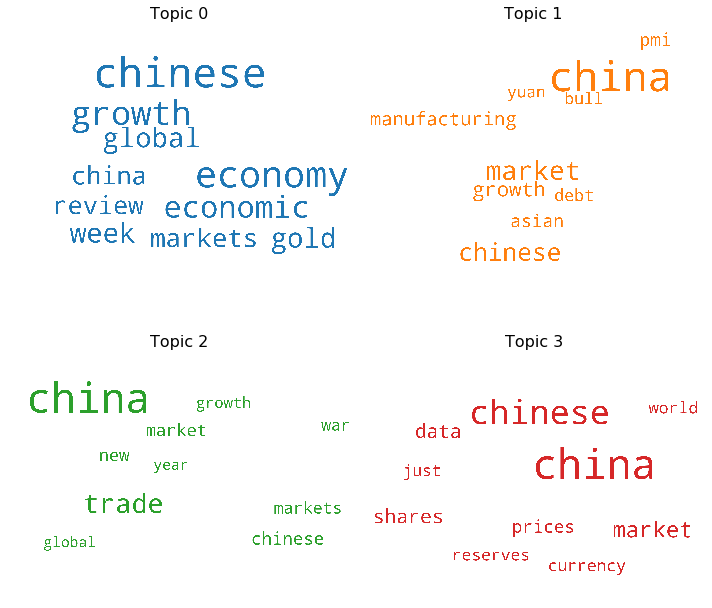

In [ ]:
##worldcloud
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = ldamodel4.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
##topic modeling for PGJ 
import re
from sklearn import feature_extraction 
stop_words = feature_extraction.text.ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

import nltk 
nltk.download('words')
words = set(nltk.corpus.words.words())

import preprocessor as p
p.set_options(p.OPT.URL, p.OPT.EMOJI,p.OPT.MENTION,p.OPT.HASHTAG)
p.set_options(p.OPT.URL, p.OPT.EMOJI,p.OPT.MENTION)

def remove_html_tags(text):
    """Remove html tags from a string"""
    import re
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

def preprocess(text):
  text = text.lower() #lowercase
  text = p.clean(text)
  text = remove_html_tags(text)
  # text = " ".join(w for w in nltk.wordpunct_tokenize(text) if w.lower() in words or not w.isalpha()) #non-English
  text = re.sub(r'[^\w\s]', '', text) #remove punctuations
  text = re.sub(r'\d+', '', text) #remove numbers
  text = " ".join(text.split()) #stripWhitespace
  text = text.split()
  text = [x for x in text if x not in stop_words] #remove stopwords
  text = [x for x in text if x not in ['chinas','stock','stocks',"q",'results','blog','outlook','analyst']] #remove task specific stopwords
  text = [x for x in text if len(x)>2]
  text = " ".join(text)
  # stemmer_ps = PorterStemmer()  
  # text = [stemmer_ps.stem(word) for word in text.split()] #stemming
  # text = " ".join(text)
  # lemmatizer = WordNetLemmatizer()
  # text = [lemmatizer.lemmatize(word) for word in text.split()]  #lemmatization
  # text = " ".join(text)
  return(text)


data7['text_processed']=data7['headline'].apply(lambda x:preprocess(str(x)))
data7['text_processed']=data7['text_processed'].apply(lambda x:x.split())

from gensim import corpora
dictionary = corpora.Dictionary(data7['text_processed'])
dictionary.filter_extremes(keep_n=5000)
data7['text_ids']=data7['text_processed'].apply(lambda x:dictionary.doc2bow(x))
from gensim import models
num_topics=4
ldamodel5 = models.ldamodel.LdaModel(data7['text_ids'], num_topics = 4, id2word=dictionary, passes=1, random_state=100)

topics = ldamodel5.print_topics(num_words=8)
for i in range(num_topics):
    print(topics[i])

[nltk_data] Downloading package words to /Users/rookie/nltk_data...
[nltk_data]   Package words is already up-to-date!
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

(0, '0.172*"china" + 0.052*"chinese" + 0.025*"market" + 0.017*"new" + 0.015*"data" + 0.012*"etfs" + 0.012*"pboc" + 0.011*"year"')
(1, '0.116*"china" + 0.036*"growth" + 0.025*"chinese" + 0.024*"markets" + 0.023*"market" + 0.021*"trade" + 0.021*"data" + 0.018*"economy"')
(2, '0.060*"china" + 0.039*"economic" + 0.039*"trade" + 0.026*"week" + 0.023*"chinese" + 0.021*"international" + 0.019*"growth" + 0.017*"review"')
(3, '0.098*"china" + 0.046*"chinese" + 0.024*"commentary" + 0.016*"etf" + 0.016*"trade" + 0.015*"rally" + 0.015*"bank" + 0.014*"record"')


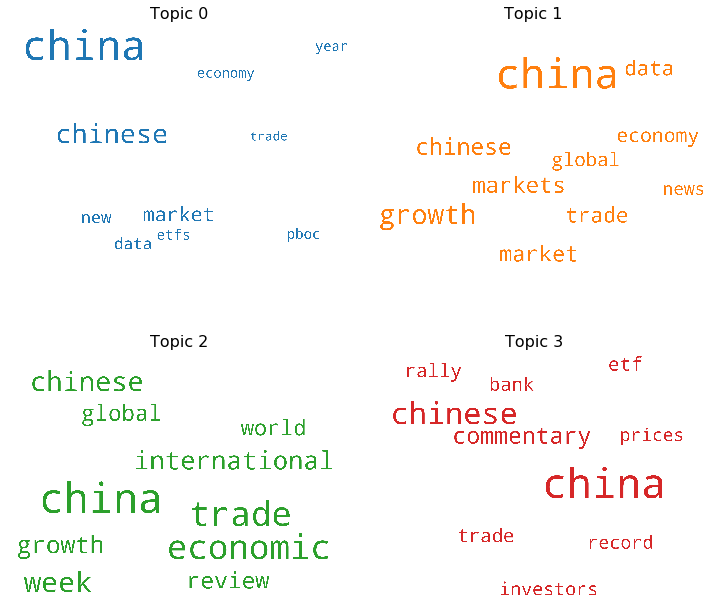

In [ ]:
##worldcloud
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = ldamodel5.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
##topic modeling for JPM 
import re
from sklearn import feature_extraction 
stop_words = feature_extraction.text.ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

import nltk 
nltk.download('words')
words = set(nltk.corpus.words.words())

import preprocessor as p
p.set_options(p.OPT.URL, p.OPT.EMOJI,p.OPT.MENTION,p.OPT.HASHTAG)
p.set_options(p.OPT.URL, p.OPT.EMOJI,p.OPT.MENTION)

def remove_html_tags(text):
    """Remove html tags from a string"""
    import re
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

def preprocess(text):
  text = text.lower() #lowercase
  text = p.clean(text)
  text = remove_html_tags(text)
  # text = " ".join(w for w in nltk.wordpunct_tokenize(text) if w.lower() in words or not w.isalpha()) #non-English
  text = re.sub(r'[^\w\s]', '', text) #remove punctuations
  text = re.sub(r'\d+', '', text) #remove numbers
  text = " ".join(text.split()) #stripWhitespace
  text = text.split()
  text = [x for x in text if x not in stop_words] #remove stopwords
  text = [x for x in text if x not in ['chinas','stock','stocks',"q",'results','blog','outlook','analyst','jpmorgan','breakfast','jpm']] #remove task specific stopwords
  text = [x for x in text if len(x)>2]
  text = " ".join(text)
  # stemmer_ps = PorterStemmer()  
  # text = [stemmer_ps.stem(word) for word in text.split()] #stemming
  # text = " ".join(text)
  # lemmatizer = WordNetLemmatizer()
  # text = [lemmatizer.lemmatize(word) for word in text.split()]  #lemmatization
  # text = " ".join(text)
  return(text)


data8['text_processed']=data8['headline'].apply(lambda x:preprocess(str(x)))
data8['text_processed']=data8['text_processed'].apply(lambda x:x.split())

from gensim import corpora
dictionary = corpora.Dictionary(data8['text_processed'])
dictionary.filter_extremes(keep_n=5000)
data8['text_ids']=data8['text_processed'].apply(lambda x:dictionary.doc2bow(x))
from gensim import models
num_topics=4
ldamodel6 = models.ldamodel.LdaModel(data8['text_ids'], num_topics = 4, id2word=dictionary, passes=1, random_state=100)

topics = ldamodel6.print_topics(num_words=8)
for i in range(num_topics):
    print(topics[i])

[nltk_data] Downloading package words to /Users/rookie/nltk_data...
[nltk_data]   Package words is already up-to-date!
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

(0, '0.064*"earnings" + 0.044*"bank" + 0.025*"financial" + 0.019*"wells" + 0.018*"fargo" + 0.017*"zacks" + 0.014*"highlights" + 0.014*"citigroup"')
(1, '0.040*"buys" + 0.036*"dividend" + 0.024*"growth" + 0.023*"portfolio" + 0.022*"sells" + 0.021*"corp" + 0.019*"chase" + 0.017*"bank"')
(2, '0.040*"chase" + 0.037*"market" + 0.020*"buys" + 0.015*"news" + 0.015*"banks" + 0.015*"investing" + 0.015*"earnings" + 0.014*"know"')
(3, '0.032*"banks" + 0.029*"street" + 0.029*"wall" + 0.023*"dow" + 0.021*"big" + 0.020*"bank" + 0.018*"market" + 0.017*"earnings"')


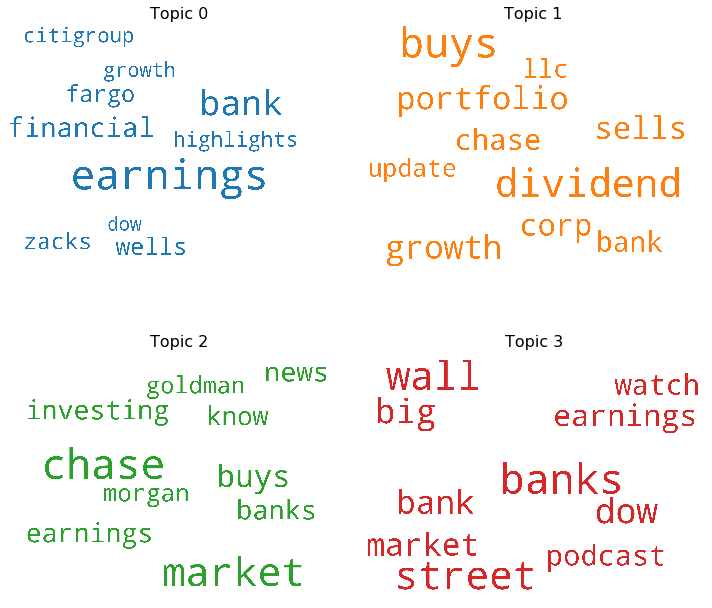

In [ ]:
##worldcloud
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = ldamodel6.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()